# Bitcoin Price Prediction using AI Models


### Elastic Net • XGBoost • LSTM

## Setup & Imports

In [2]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Deep learning
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Misc
import math


In [3]:
import os, random, numpy as np, tensorflow as tf

# Results deterministic
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

## Load & Inspect Dataset

In [4]:
# Load dataset
df = pd.read_csv(r"C:\Users\Minec\Desktop\BTC-Price-Predictor\data\BTC_USD_COMPLETE_ANALYSIS_20250907_220628.csv")

print("Shape:", df.shape)
df.head()

Shape: (4009, 113)


,Date,open,high,low,close,volume,daily_return_pct,weekly_return_pct,monthly_return_pct,yearly_return_pct,...,high_volume_breakout,golden_cross,death_cross,breakout_20d_high,breakdown_20d_low,rsi_overbought,rsi_oversold,rsi_divergence,macd_bullish_cross,macd_bearish_cross
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,-7.192558,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,True
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,-6.984265,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,3.573492,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,-2.465854,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False


## Preprocessing & Train / Validation / Test Split

In [5]:
data = df.copy()

# Convert Date column to datetime and sort by date
if "Date" in data.columns:
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.sort_values("Date").reset_index(drop=True)

# next-day close price
#    target_close_1d = tomorrow's close
data["target_close_1d"] = data["close"].shift(-1)

# Drop the last row 
data = data.dropna(subset=["target_close_1d"]).reset_index(drop=True)

# Handle missing values in features 
data = data.fillna(method="ffill").fillna(method="bfill")

# feature matrix X and target vector y
#    - target_close_1d (our label)
#    - close (today's close, to avoid leaking exact target)

drop_cols = ["target_close_1d", "close"]

numeric_cols = data.select_dtypes(include=[np.number, bool]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in drop_cols]

X = data[feature_cols].astype(float)
y = data["target_close_1d"].astype(float)

print("Number of features:", len(feature_cols))

# Time-based split: 70% train, 15% val, 15% test
n = len(data)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val,   y_val   = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]

print("Total samples:", n)
print("Train size:   ", len(X_train))
print("Val size:     ", len(X_val))
print("Test size:    ", len(X_test))


Number of features: 109
Total samples: 4008
Train size:    2805
Val size:      601
Test size:     602


C:\Users\Minec\AppData\Local\Temp\ipykernel_30080\1627349610.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")


## Evaluation Metrics

In [6]:
# Regression evaluation: MAE, RMSE, R^2
def evaluate_regression(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name}")
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R^2  :", r2)

    return mae, rmse, r2


# Directional accuracy 
def directional_accuracy(y_true, y_pred, prev_close):
    """
    y_true: actual next-day close
    y_pred: predicted next-day close
    prev_close: today's closing price (used to determine trend direction)
    """
    true_up = (y_true.values > prev_close.values)
    pred_up = (y_pred > prev_close.values)
    return (true_up == pred_up).mean()


## Prepare Previous-Day Close (for Trend Direction Evaluation)


In [7]:
# prev_close_test = today's closing price for each test row
# (so we can compare if price goes up or down tomorrow)

prev_close_test = data["close"].iloc[val_end:]  # same index as X_test and y_test

print("prev_close_test length:", len(prev_close_test))
prev_close_test.head()


prev_close_test length: 602


3406    41796.269531
3407    42511.968750
3408    43154.945312
3409    42742.652344
3410    41262.058594
Name: close, dtype: float64

# Model Testing

# Model 1: Elastic Net (baseline)

In [10]:
# Elastic Net baseline model
elasticnet = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(
        alpha=0.1,        # regularization strength
        l1_ratio=0.5,     # mix between L1 (Lasso) and L2 (Ridge)
        max_iter=10000,
        random_state=42
    ))
])

# Train the model
elasticnet.fit(X_train, y_train)

# Predictions
y_train_pred_en = elasticnet.predict(X_train)
y_val_pred_en   = elasticnet.predict(X_val)
y_test_pred_en  = elasticnet.predict(X_test)

# Evaluate on train / val / test
en_train_metrics = evaluate_regression("Elastic Net (Train)", y_train, y_train_pred_en)
en_val_metrics   = evaluate_regression("Elastic Net (Val)",   y_val,   y_val_pred_en)
en_test_metrics  = evaluate_regression("Elastic Net (Test)",  y_test,  y_test_pred_en)

# Directional accuracy on test set
da_en_test = directional_accuracy(y_test, y_test_pred_en, prev_close_test)
print("\nElastic Net Directional Accuracy (Test):", da_en_test)


Elastic Net (Train)
MAE : 449.5690405348561
RMSE: 872.1607634299481
R^2  : 0.9972482444064095

Elastic Net (Val)
MAE : 643.9576894190614
RMSE: 888.484251499903
R^2  : 0.9839602756555353

Elastic Net (Test)
MAE : 2024.2160887430566
RMSE: 2638.840340527955
R^2  : 0.9849025795658468

Elastic Net Directional Accuracy (Test): 0.5149501661129569


c:\Users\Minec\Desktop\BTC-Price-Predictor\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.034e+09, tolerance: 7.754e+07
  model = cd_fast.enet_coordinate_descent(


## Model 2: XGBoost Regressor

In [11]:
# XGBoost regression model

xgb = XGBRegressor(
    n_estimators=500,        # number of trees
    max_depth=6,             # tree depth
    learning_rate=0.05,      # step size shrinkage
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1                
)

# Train the model
xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predictions
y_train_pred_xgb = xgb.predict(X_train)
y_val_pred_xgb   = xgb.predict(X_val)
y_test_pred_xgb  = xgb.predict(X_test)

# Evaluate on train / val / test
xgb_train_metrics = evaluate_regression("XGBoost (Train)", y_train, y_train_pred_xgb)
xgb_val_metrics   = evaluate_regression("XGBoost (Val)",   y_val,   y_val_pred_xgb)
xgb_test_metrics  = evaluate_regression("XGBoost (Test)",  y_test,  y_test_pred_xgb)

# Directional accuracy on test set
da_xgb_test = directional_accuracy(y_test, y_test_pred_xgb, prev_close_test)
print("\nXGBoost Directional Accuracy (Test):", da_xgb_test)



XGBoost (Train)
MAE : 42.64179542255911
RMSE: 62.7469355517178
R^2  : 0.9999857569890134

XGBoost (Val)
MAE : 3133.6983738040767
RMSE: 3902.853428192537
R^2  : 0.6904991008658152

XGBoost (Test)
MAE : 21902.597253945183
RMSE: 29145.79980908726
R^2  : -0.8417406571045369

XGBoost Directional Accuracy (Test): 0.4867109634551495


## Model 2b: Tuned XGBoost (Reduced Overfitting)

In [12]:
# Tuned XGBoost model with stronger regularization to reduce overfitting

xgb_tuned = XGBRegressor(
    n_estimators=200,        # fewer trees than before
    max_depth=3,             # shallower trees (less complex)
    learning_rate=0.05,      # same step size
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    reg_lambda=2.0,          # L2 regularization (stronger)
    reg_alpha=1.0,           # L1 regularization
    min_child_weight=5,      # require more samples in leaves
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# Train the tuned model
xgb_tuned.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predictions
y_train_pred_xgb_tuned = xgb_tuned.predict(X_train)
y_val_pred_xgb_tuned   = xgb_tuned.predict(X_val)
y_test_pred_xgb_tuned  = xgb_tuned.predict(X_test)

# Evaluate on train / val / test
xgb_tuned_train_metrics = evaluate_regression("XGBoost TUNED (Train)", y_train, y_train_pred_xgb_tuned)
xgb_tuned_val_metrics   = evaluate_regression("XGBoost TUNED (Val)",   y_val,   y_val_pred_xgb_tuned)
xgb_tuned_test_metrics  = evaluate_regression("XGBoost TUNED (Test)",  y_test,  y_test_pred_xgb_tuned)

# Directional accuracy on test set
da_xgb_tuned_test = directional_accuracy(y_test, y_test_pred_xgb_tuned, prev_close_test)
print("\nXGBoost TUNED Directional Accuracy (Test):", da_xgb_tuned_test)



XGBoost TUNED (Train)
MAE : 275.2477161971855
RMSE: 553.5128965920338
R^2  : 0.9988916619154208

XGBoost TUNED (Val)
MAE : 3189.9058827735025
RMSE: 4025.610933848621
R^2  : 0.6707232779067269

XGBoost TUNED (Test)
MAE : 21052.46699802741
RMSE: 28466.284644385174
R^2  : -0.7568638053826788

XGBoost TUNED Directional Accuracy (Test): 0.5066445182724253


Deep/complex models don't automatically outperform simpler linear models on highly volatile financial time-series. The data isn't stationary, it's full of noise, the market keeps hitting random structural breaks, so even increased model complexity doesn't guarantee better predictive performance.

## 8. Model 3: LSTM (Long Short-Term Memory Network)

The shape needed: [ samples , time_steps , features ]

### Create Sequences for LSTM

In [13]:
# number of past days LSTM will look at
window_size = 30

# Scale features before sequence creation
scaler_lstm = StandardScaler()
X_scaled = scaler_lstm.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

# Function to convert time-series into sequences
def make_sequences(X_df, y_series, window):
    X_seq, y_seq, prev_close_seq = [], [], []
    closes = data["close"].values  # to compute trend later

    for i in range(window, len(X_df)):
        X_seq.append(X_df.iloc[i-window:i].values)  # window_size × features
        y_seq.append(y_series.iloc[i])              # next-day target
        prev_close_seq.append(closes[i-1])          # today's close (to determine direction)

    return np.array(X_seq), np.array(y_seq), np.array(prev_close_seq)

# Create sequences
X_seq, y_seq, prev_close_all = make_sequences(X_scaled_df, y, window_size)

# Fix alignment with earlier splits
offset = window_size
train_end_seq = train_end - offset
val_end_seq   = val_end - offset

X_train_lstm = X_seq[:train_end_seq]
y_train_lstm = y_seq[:train_end_seq]

X_val_lstm   = X_seq[train_end_seq:val_end_seq]
y_val_lstm   = y_seq[train_end_seq:val_end_seq]

X_test_lstm  = X_seq[val_end_seq:]
y_test_lstm  = y_seq[val_end_seq:]
prev_close_test_lstm = prev_close_all[val_end_seq:]

print("LSTM data shapes:")
print("Train:", X_train_lstm.shape)
print("Val:  ", X_val_lstm.shape)
print("Test: ", X_test_lstm.shape)

LSTM data shapes:
Train: (2775, 30, 109)
Val:   (601, 30, 109)
Test:  (602, 30, 109)


### Train LSTM Model

In [14]:
# Build the LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, X_train_lstm.shape[-1])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)  # predict next-day closing price
])

lstm_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mae"]
)

# Train the model
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30


c:\Users\Minec\Desktop\BTC-Price-Predictor\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 430933408.0000 - mae: 12372.0029 - val_loss: 735184704.0000 - val_mae: 26190.1914
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 430809664.0000 - mae: 12366.5459 - val_loss: 735088768.0000 - val_mae: 26188.0273
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 430732928.0000 - mae: 12363.4395 - val_loss: 735004864.0000 - val_mae: 26186.1523
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 430660448.0000 - mae: 12360.4609 - val_loss: 734933440.0000 - val_mae: 26184.5020
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 430583840.0000 - mae: 12357.5117 - val_loss: 734864192.0000 - val_mae: 26182.8848
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 430516832.0000 - mae: 12354.6621 - val_loss: 734790912.0000 - val_mae: 26181.2070
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 430445824.0000 - mae: 12351.7998 - val_loss: 734715456.0000 - val_mae: 26179.4863
Epoch 8/30
87/87 ━━━━━━━━━━━━━━

### Evaluate LSTM on Test Set

In [15]:
# Predictions for LSTM
y_train_pred_lstm = lstm_model.predict(X_train_lstm).flatten()
y_val_pred_lstm   = lstm_model.predict(X_val_lstm).flatten()
y_test_pred_lstm  = lstm_model.predict(X_test_lstm).flatten()

# Evaluate on train / val / test
lstm_train_metrics = evaluate_regression("LSTM (Train)", y_train_lstm, y_train_pred_lstm)
lstm_val_metrics   = evaluate_regression("LSTM (Val)",   y_val_lstm,   y_val_pred_lstm)
lstm_test_metrics  = evaluate_regression("LSTM (Test)",  y_test_lstm,  y_test_pred_lstm)

# Directional accuracy on test set
da_lstm_test = directional_accuracy(
    pd.Series(y_test_lstm),
    y_test_pred_lstm,
    pd.Series(prev_close_test_lstm)
)
print("\nLSTM Directional Accuracy (Test):", da_lstm_test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

LSTM (Train)
MAE : 12286.388182628734
RMSE: 20708.297013352305
R^2  : -0.5432427489763698

LSTM (Val)
MAE : 26139.83485783654
RMSE: 27073.169163924944
R^2  : -13.892774909004565

LSTM (Test)
MAE : 81040.27938665682
RMSE: 83838.96831308278
R^2  : -14.239417638153979

LSTM Directional Accuracy (Test): 0.4700996677740864


## Conclusion

For predicting Bitcoin closing price and trend, simpler linear models (Elastic Net) generalized better than deep learning (LSTM) and ensemble trees (XGBoost), because the crypto market is extremely volatile and driven by external non-numerical events that models cannot learn from price history alone.

- Elastic Net: Was most stable
- XGBoost: Overfits price jumps
- LSTM: Underfits trend patterns

## Model Comparison Summary

In [17]:
results_data = {
    "Model": [
        "Elastic Net",
        "XGBoost",
        "XGBoost Tuned",
        "LSTM"
    ],
    "MAE (Test)": [
        en_test_metrics[0],
        xgb_test_metrics[0],
        xgb_tuned_test_metrics[0],
        lstm_test_metrics[0],
    ],
    "RMSE (Test)": [
        en_test_metrics[1],
        xgb_test_metrics[1],
        xgb_tuned_test_metrics[1],
        lstm_test_metrics[1],
    ],
    "R² (Test)": [
        en_test_metrics[2],
        xgb_test_metrics[2],
        xgb_tuned_test_metrics[2],
        lstm_test_metrics[2],
    ],
    "Directional Accuracy": [
        da_en_test,
        da_xgb_test,
        da_xgb_tuned_test,
        da_lstm_test,
    ],
}

results_df = pd.DataFrame(results_data)
results_df


,Model,MAE (Test),RMSE (Test),R² (Test),Directional Accuracy
0,Elastic Net,2024.216089,2638.840341,0.984903,0.514950
1,XGBoost,21902.597254,29145.799809,-0.841741,0.486711
2,XGBoost Tuned,21052.466998,28466.284644,-0.756864,0.506645
3,LSTM,81040.279387,83838.968313,-14.239418,0.470100


## Visualization - Actual vs Predicted (Elastic Net)

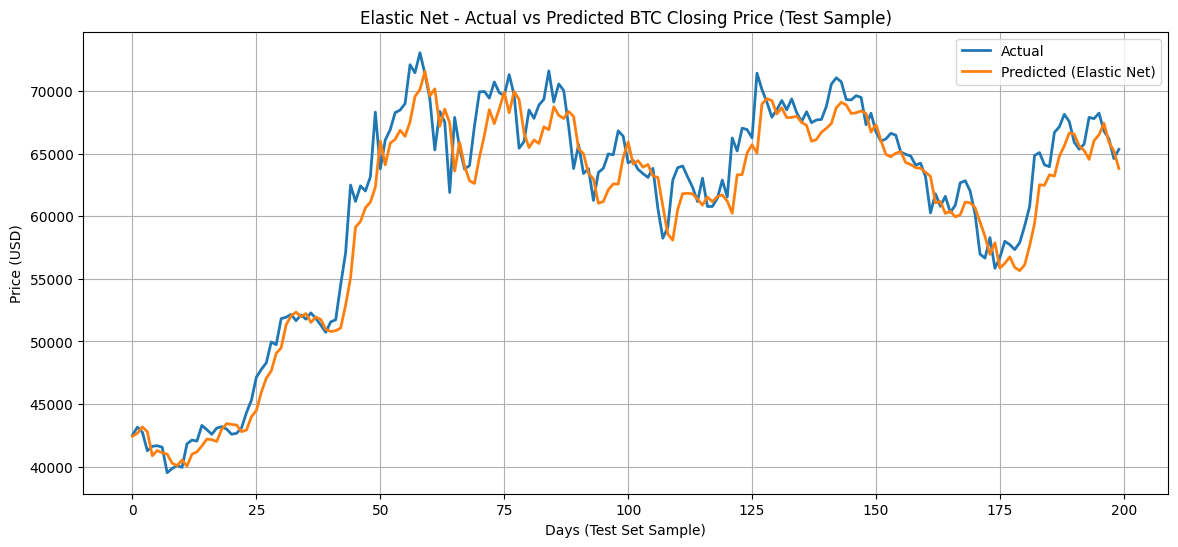

In [29]:
# Actual vs Predicted closing price for Elastic Net

plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:200], label="Actual", linewidth=2)                   # first 200 test points
plt.plot(y_test_pred_en[:200], label="Predicted (Elastic Net)", linewidth=2)
plt.title("Elastic Net - Actual vs Predicted BTC Closing Price (Test Sample)")
plt.xlabel("Days (Test Set Sample)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


## Visualization - Actual vs Predicted (XGBoost)

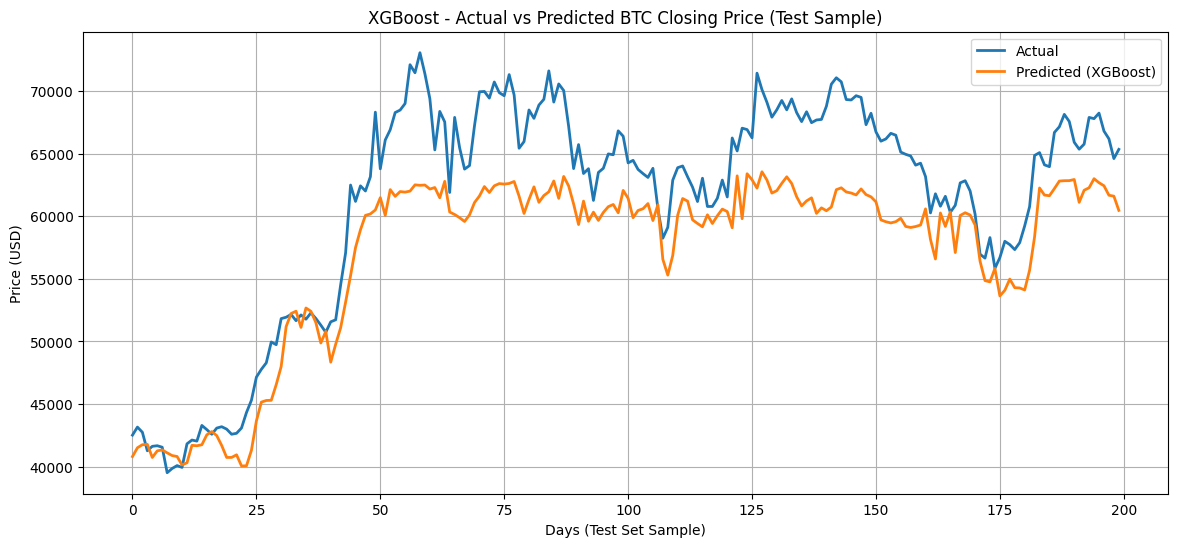

In [30]:
# Actual vs Predicted BTC closing price for XGBoost (same first 200 samples)

plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:200], label="Actual", linewidth=2)
plt.plot(y_test_pred_xgb[:200], label="Predicted (XGBoost)", linewidth=2)
plt.title("XGBoost - Actual vs Predicted BTC Closing Price (Test Sample)")
plt.xlabel("Days (Test Set Sample)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

## Visualization - LSTM Training Loss Curve

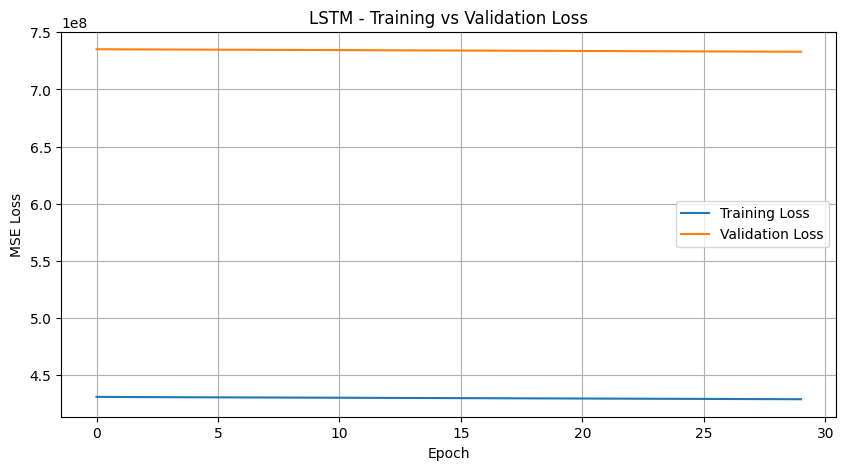

In [31]:
# Plot training vs validation loss curve for LSTM

plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("LSTM - Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


## Visualization - Actual vs Predicted (Elastic Net vs XGBoost)

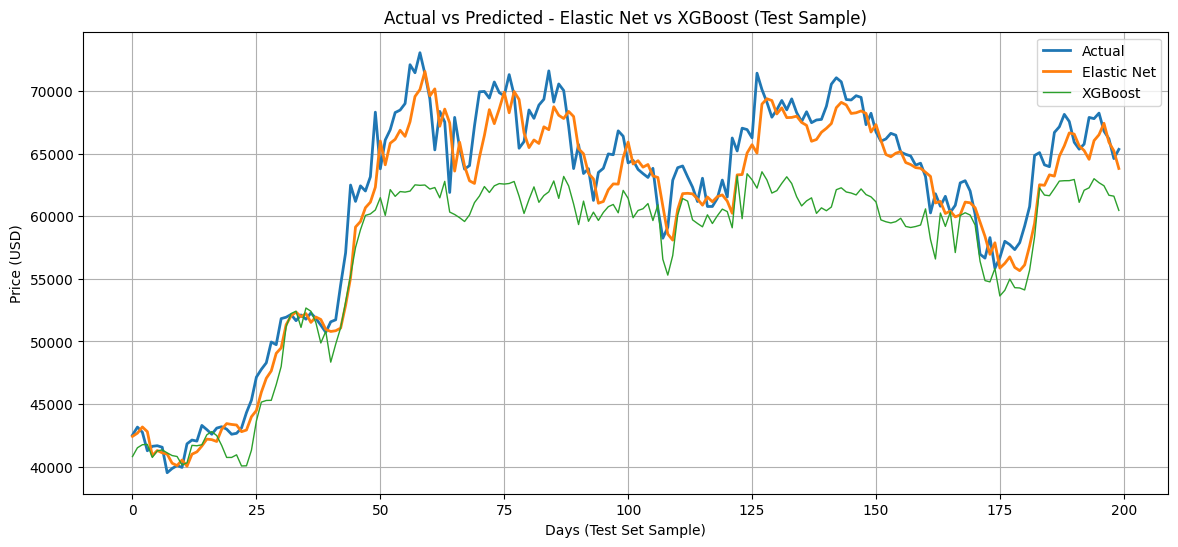

In [32]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:200], label="Actual", linewidth=2)
plt.plot(y_test_pred_en[:200], label="Elastic Net", linewidth=2)
plt.plot(y_test_pred_xgb[:200], label="XGBoost", linewidth=1)
plt.title("Actual vs Predicted - Elastic Net vs XGBoost (Test Sample)")
plt.xlabel("Days (Test Set Sample)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()
